# Network training

For our project, we constructed a Detection Transformer (DeTR) instance that we named `GlowDeTR` to assess how light exposure affects Neural Network's result at classification.

In [1]:
import torch
import json
import ast
import torch.nn as nn
import numpy as np
import albumentations
from math import floor
from tqdm import tqdm

from pathlib import Path
from PIL import Image, ImageDraw
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTModel, AutoModelForObjectDetection, AutoImageProcessor, TrainingArguments, Trainer, get_scheduler
from datasets import load_dataset, Dataset
from tenacity import retry, wait_fixed, stop_after_attempt

# huggingface-cli download yin30lei/day_and_night_traffic_lights --repo-type dataset --local-dir ./traffic_lights

2024-11-26 02:33:10.389030: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 02:33:10.435198: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 02:33:10.435242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 02:33:10.436533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 02:33:10.444903: I tensorflow/core/platform/cpu_feature_guar

uintx feature requires torch 2.3+, please upgrade pytorch


In [2]:
wildlife_ds = load_dataset("SeaSponge/wildme_dataset", cache_dir=Path.cwd() / "yalu_dataset", num_proc=2)

In [3]:
# class GlowDeTR(nn.Module):
#     def __init__(self, pretrained_name="facebook/detr-resnet-50", ignore_mismatch_sz=True, id2label=None, label2id=None):
#         super(GlowDeTR, self).__init__()
#         # Load pretrained ViT backbone
#         self.detr = AutoModelForObjectDetection.from_pretrained(
#             pretrained_name,
#             id2label=id2label,
#             label2id=label2id,
#             ignore_mismatched_sizes=ignore_mismatch_sz)    

#     def forward(self, **kwargs):
#         # Pass through the ViT backbone
#         return self.detr(**kwargs)

class GlowDeTR(AutoModelForObjectDetection):
    def help():
        print(AutoModelForObjectDetection.__doc__)

tensor2PIL = transforms.ToPILImage()

transform1 = albumentations.Compose(
    [
        albumentations.HorizontalFlip(p=0.5),
        albumentations.LongestMaxSize(max_size=600),  # Resize while keeping aspect ratio
        # albumentations.PadIfNeeded(min_height=480, min_width=480, border_mode=0),  # Pad to 480x480
        albumentations.RandomBrightnessContrast(p=0.5),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

checkpoint = "facebook/detr-resnet-50"

device = "cuda" if torch.cuda.is_available else "cpu"

In [4]:
print(wildlife_ds)
print(wildlife_ds["train"])
print(wildlife_ds["validation"])

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 1481
    })
    validation: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 381
    })
    test: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 254
    })
})
Dataset({
    features: ['image', 'image_id', 'width', 'height', 'objects'],
    num_rows: 1481
})
Dataset({
    features: ['image', 'image_id', 'width', 'height', 'objects'],
    num_rows: 381
})


In [5]:
# Two labels: leopard & hyenas
wildlife_train_ds = wildlife_ds["train"]
wildlife_val_ds = wildlife_ds["validation"]
del wildlife_ds

In [6]:
def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["bbox"])):
        box = annotations["bbox"][i]
        class_idx = annotations["label"][i]
        x, y, w, h = tuple(box)
        if max(box) > 1.0:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        print(f"height -> {height} | width -> {width}")
        print(f"x1 -> {x1} | y1 -> {y1} | x2 -> {x2} | y2 -> {y2}")
        draw.rectangle((x1, y1, x2, y2), outline="red", width=6)
        draw.text((x1, y1), annotations["label"], fill="white", font_size=40)
    return image

height -> 1800 | width -> 2400
x1 -> 477 | y1 -> 1062 | x2 -> 1212 | y2 -> 1575


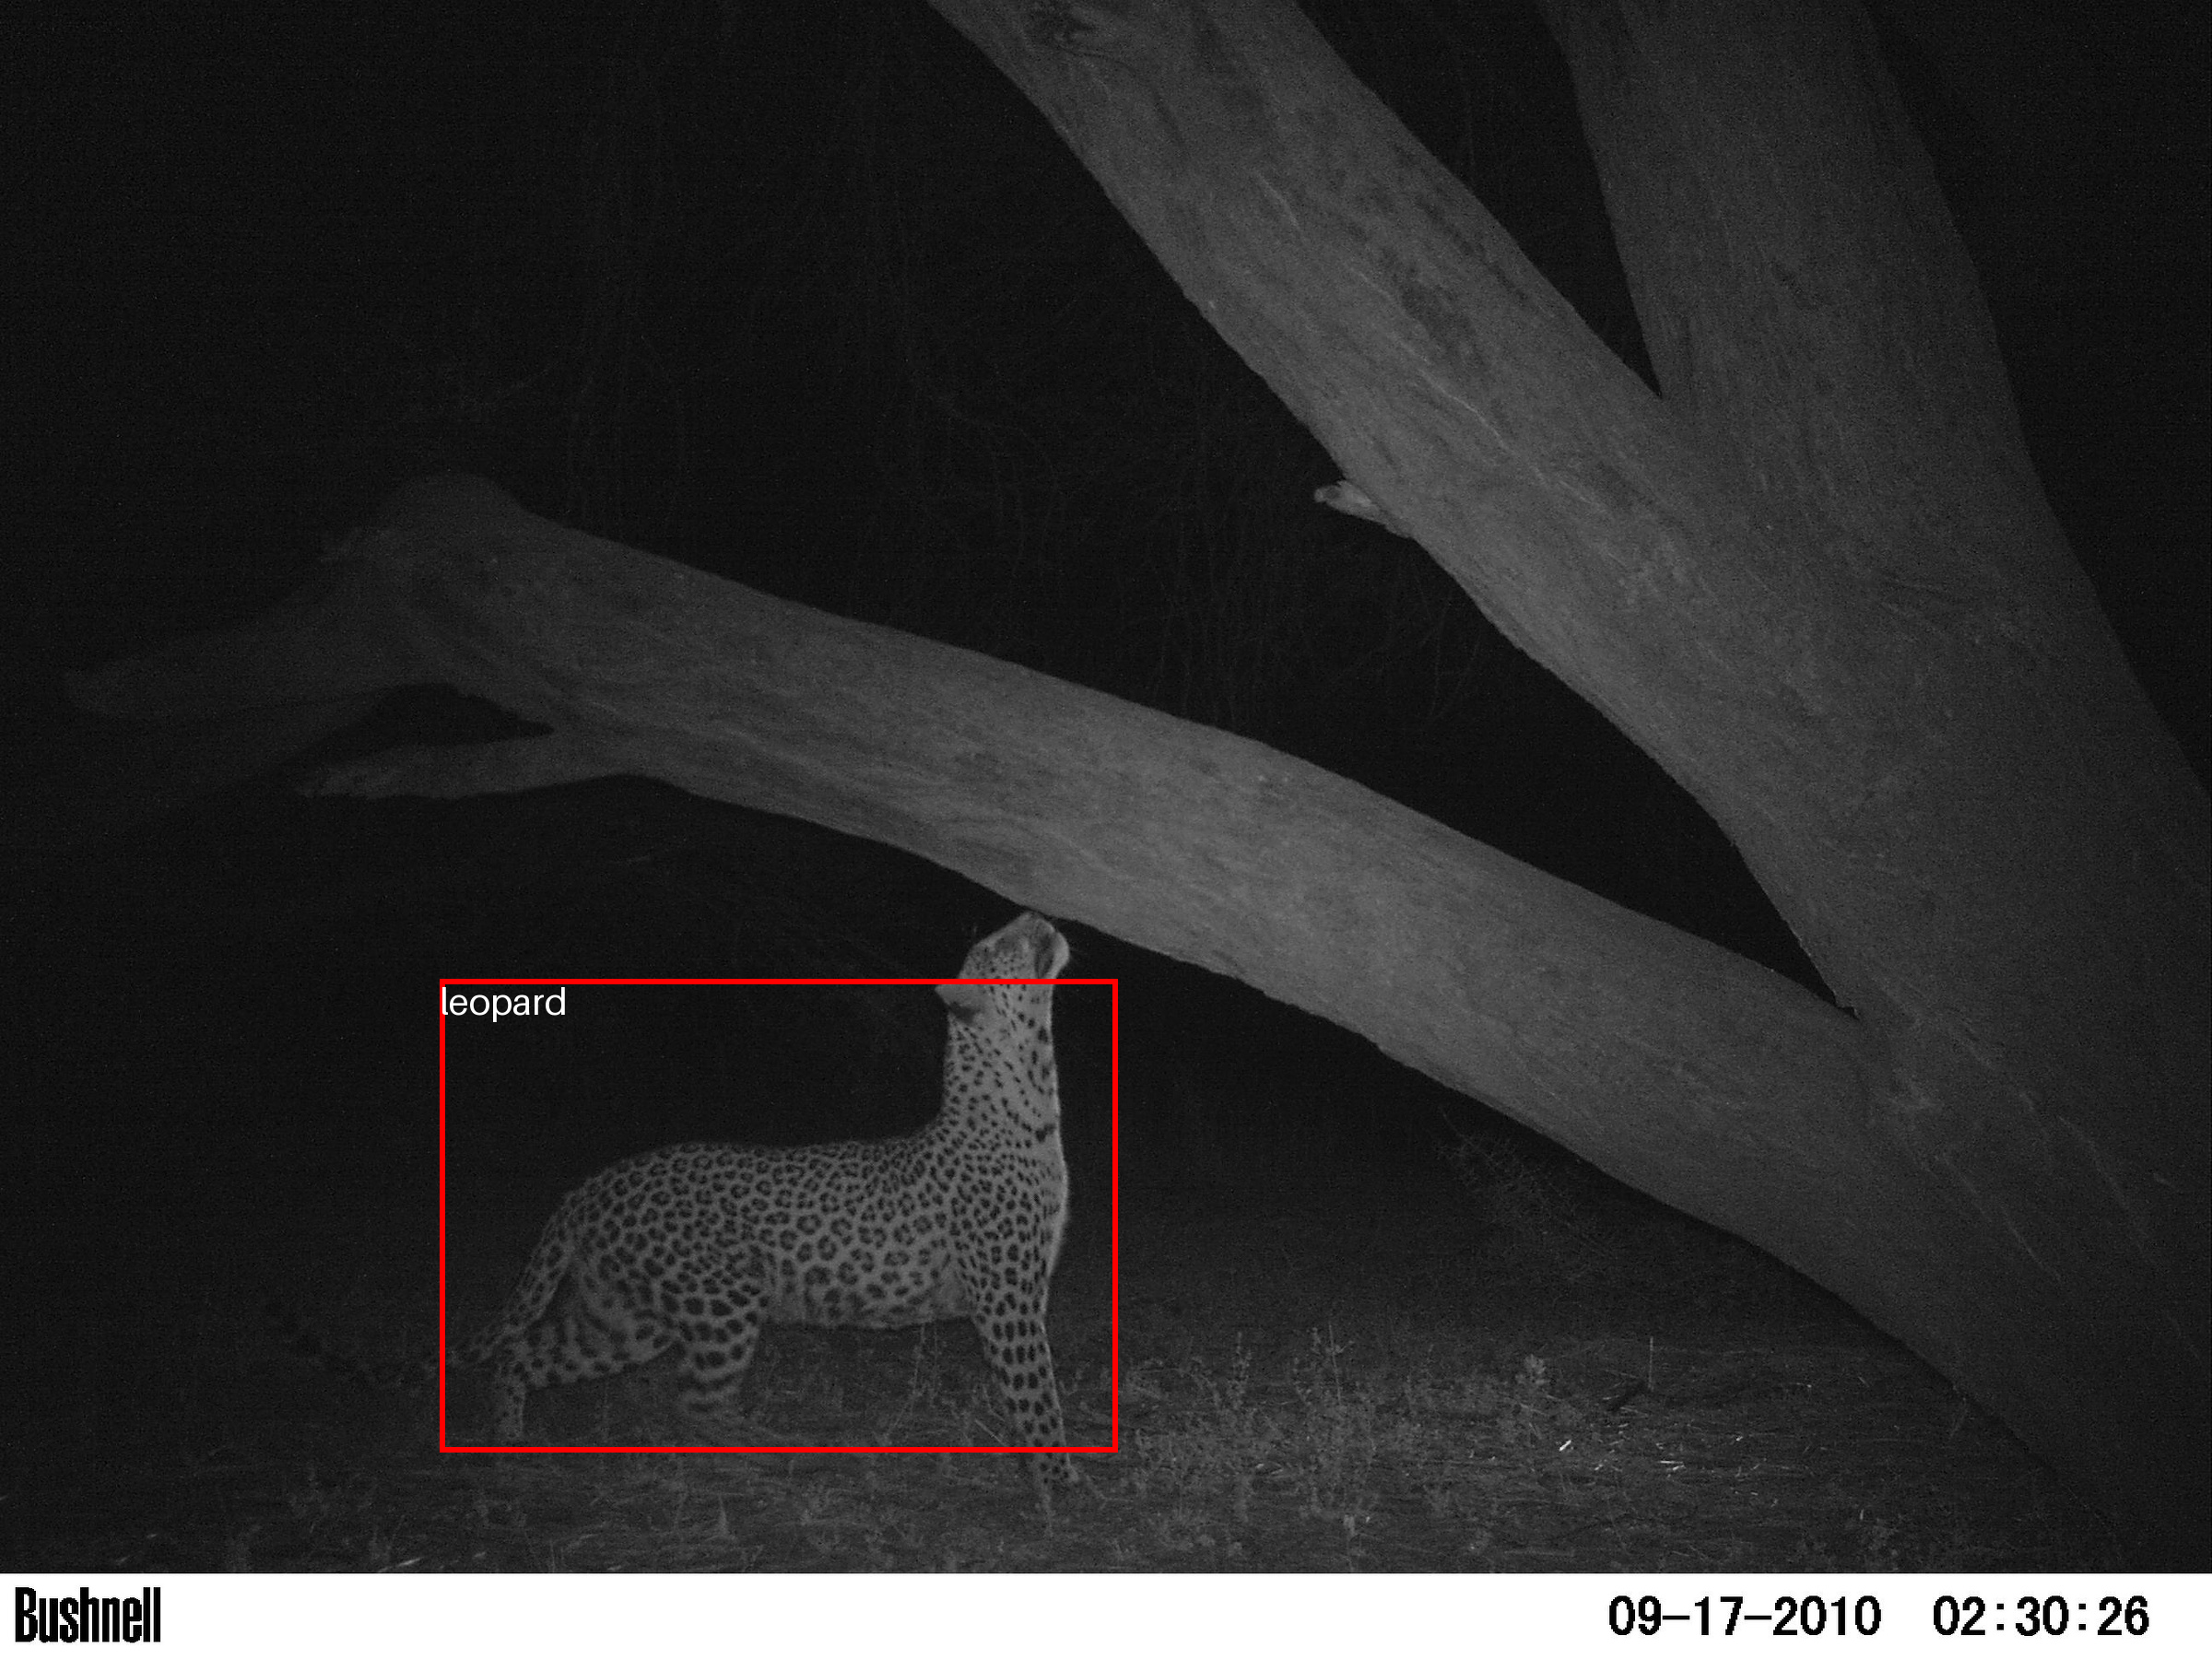

In [7]:
draw_image_from_idx(dataset=wildlife_train_ds, idx=10)

height -> 1800 | width -> 2400
x1 -> 109 | y1 -> 868 | x2 -> 1532 | y2 -> 1712
height -> 1800 | width -> 2400
x1 -> 304 | y1 -> 513 | x2 -> 2147 | y2 -> 1390
height -> 1800 | width -> 2400
x1 -> 1383 | y1 -> 821 | x2 -> 2331 | y2 -> 1323
height -> 1800 | width -> 2400
x1 -> 0 | y1 -> 185 | x2 -> 1762 | y2 -> 1800
height -> 1600 | width -> 2400
x1 -> 0 | y1 -> 607 | x2 -> 1323 | y2 -> 1800
height -> 1800 | width -> 2400
x1 -> 0 | y1 -> 1150 | x2 -> 522 | y2 -> 1792
height -> 2032 | width -> 2400
x1 -> 58 | y1 -> 0 | x2 -> 2391 | y2 -> 1965
height -> 1597 | width -> 2400
x1 -> 797 | y1 -> 419 | x2 -> 1469 | y2 -> 1480
height -> 1800 | width -> 2400
x1 -> 1453 | y1 -> 623 | x2 -> 2050 | y2 -> 1191


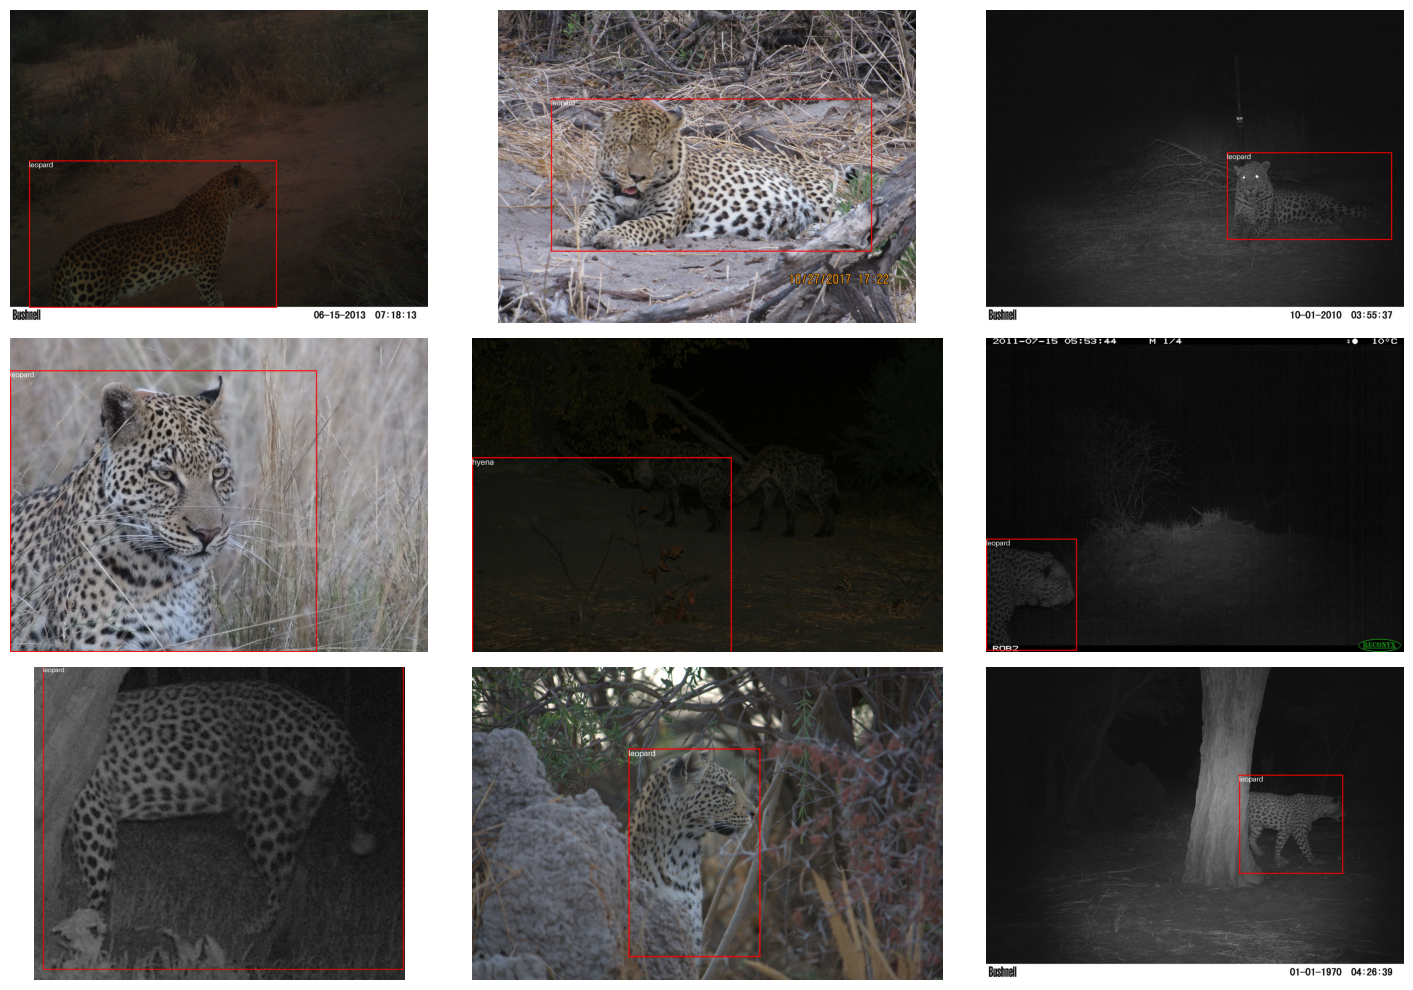

In [8]:
import matplotlib.pyplot as plt


def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = draw_image_from_idx(dataset, idx)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


# Now use the function to plot images

plot_images(wildlife_train_ds, range(9))

In [9]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [10]:
def normalize_bboxes(bboxes, img_width, img_height):
    normalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, width, height = bbox
        x_max = x_min + width
        y_max = y_min + height
        # Normalize to [0, 1]
        normalized_bboxes.append([
            x_min / img_width,
            y_min / img_height,
            x_max / img_width,
            y_max / img_height,
        ])
    return normalized_bboxes

# transforming a batch


def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        #! category needs to be list, hence I put the extra brackets around it
        out = transform1(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [11]:
wildlife_train_ds_transformed = wildlife_train_ds.with_transform(transform_aug_ann)
wildlife_val_ds_transformed = wildlife_val_ds.with_transform(transform_aug_ann)

In [12]:
print(wildlife_train_ds_transformed)
print(wildlife_val_ds_transformed)
del wildlife_train_ds
del wildlife_val_ds

Dataset({
    features: ['image', 'image_id', 'width', 'height', 'objects'],
    num_rows: 1481
})
Dataset({
    features: ['image', 'image_id', 'width', 'height', 'objects'],
    num_rows: 381
})


In [13]:
label2id = {"leopard" : 0, "hyena": 1}
id2label = {v:k for k, v in label2id.items()}

In [14]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [15]:
# hf_path = "SeaSponge/glow-detr-resnet-50"
# model = AutoModelForObjectDetection.from_pretrained(
#             hf_path,
#             id2label=id2label,
#             label2id=label2id,
#             ignore_mismatched_sizes=True)

# image_processor = AutoImageProcessor.from_pretrained(hf_path)

In [18]:

model = GlowDeTR.from_pretrained(
                checkpoint,
                id2label=id2label,
                label2id=label2id,
                ignore_mismatched_sizes=True)
# help(model.detr)

# model = AutoModelForObjectDetection.from_pretrained(
#             checkpoint,
#             id2label=id2label,
#             label2id=label2id,
#             ignore_mismatched_sizes=True)
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [19]:
# Define the training arguments

#! with DeTR, batchsz=4 doesn't work, has to be <= 2

training_args = TrainingArguments(
    output_dir="glow-detr-resnet-50",
    per_device_train_batch_size=2,
    # num_train_epochs=20,
    max_steps=2000,
    fp16=True,
    save_steps=10,
    logging_steps=30,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    lr_scheduler_type="cosine_with_restarts",  # Cosine scheduler with restarts
)


# Define the trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=wildlife_train_ds_transformed,
    eval_dataset=wildlife_val_ds_transformed,
    tokenizer=image_processor,
)

trainer.train()
# saved_path = Path.cwd() / "results"
# trainer.save_model(saved_path)

/tmp/ipykernel_1393/3855479407.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
max_steps is given, it will override any value given in num_train_epochs
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


TrainOutput(global_step=2000, training_loss=2.366978944778442, metrics={'train_runtime': 1613.2746, 'train_samples_per_second': 2.479, 'train_steps_per_second': 1.24, 'total_flos': 2.885936471114646e+18, 'train_loss': 2.366978944778442, 'epoch': 2.699055330634278})